In [23]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling

In [24]:
class SOM:
    def __init__(self, x, y, input_len, learning_rate=0.5, sigma=None, max_iter=1000):
        self.x = x
        self.y = y
        self.input_len = input_len
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma else max(x, y) / 2.0
        self.max_iter = max_iter
        self.weights = np.random.rand(x, y, input_len)
        self._xx, self._yy = np.meshgrid(np.arange(x), np.arange(y))

    def _neighborhood(self, winner, iteration):
        sigma = self.sigma * np.exp(-iteration / self.max_iter)
        d = (self._xx - winner[0]) ** 2 + (self._yy - winner[1]) ** 2
        return np.exp(-d / (2 * sigma ** 2))

    def _learning_rate(self, iteration):
        return self.learning_rate * np.exp(-iteration / self.max_iter)

    def winner(self, x):
        diff = self.weights - x
        dist = np.linalg.norm(diff, axis=2)
        return np.unravel_index(np.argmin(dist), (self.x, self.y))

    def train(self, data):
        for it in range(self.max_iter):
            idx = np.random.randint(0, data.shape[0])
            v = data[idx]
            win = self.winner(v)
            lr = self._learning_rate(it)
            nb = self._neighborhood(win, it)
            for i in range(self.x):
                for j in range(self.y):
                    self.weights[i, j] += lr * nb[i, j] * (v - self.weights[i, j])

    def map_vects(self, data):
        mapped = np.zeros((data.shape[0], 2), dtype=int)
        for i, v in enumerate(data):
            mapped[i] = self.winner(v)
        return mapped

In [25]:
def load_multispectral_image(filepath):
    img = io.imread(filepath)
    img = img.astype(np.float32)
    img /= img.max()
    return img

def reshape_image_to_vectors(img):
    h, w, bands = img.shape
    return img.reshape(-1, bands), h, w

def reconstruct_image_from_vectors(vectors, h, w, bands):
    return vectors.reshape(h, w, bands)

In [26]:
def compress_image_with_som(img, som):
    vectors, h, w = reshape_image_to_vectors(img)
    bmus = som.map_vects(vectors)
    compressed_vectors = np.zeros_like(vectors)
    for i, (bx, by) in enumerate(bmus):
        compressed_vectors[i] = som.weights[bx, by]
    return reconstruct_image_from_vectors(compressed_vectors, h, w, img.shape[2])

In [27]:
def compute_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

In [41]:
band_img_files = [
    "C:/Users/Pushp Raj Choudhary/Downloads/Browser_images_3/2024-11-01-00_00_2025-05-01-23_59_Sentinel-2_L2A_B02_(Raw).tiff",
    "C:/Users/Pushp Raj Choudhary/Downloads/Browser_images_3/2024-11-01-00_00_2025-05-01-23_59_Sentinel-2_L2A_B03_(Raw).tiff",
    "C:/Users/Pushp Raj Choudhary/Downloads/Browser_images_3/2024-11-01-00_00_2025-05-01-23_59_Sentinel-2_L2A_B04_(Raw).tiff",
    "C:/Users/Pushp Raj Choudhary/Downloads/Browser_images_3/2024-11-01-00_00_2025-05-01-23_59_Sentinel-2_L2A_B08_(Raw).tiff",
]

ref_band_path = band_img_files[0]
with rasterio.open(ref_band_path) as ref:
    ref_meta = ref.meta.copy()
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_shape = (ref.height, ref.width)

bands_data = []

for band_file in band_img_files:
    with rasterio.open(band_file) as src:
        data = np.zeros(ref_shape, dtype=src.meta['dtype'])
        rasterio.warp.reproject(
            source=src.read(1),
            destination=data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.nearest 
        )
        bands_data.append(data)

bands_array = np.stack(bands_data, axis=0)

ref_meta.update(count=len(band_img_files))

output_path = 'C:/Users/Pushp Raj Choudhary/Downloads/combined_multiband_gnr.tif'
with rasterio.open(output_path, 'w', **ref_meta) as dst:
    for i in range(len(band_img_files)):
        dst.write(bands_array[i], i + 1)  

print(f"Multi-band TIFF saved to {output_path}")

Multi-band TIFF saved to C:/Users/Pushp Raj Choudhary/Downloads/combined_multiband_gnr.tif


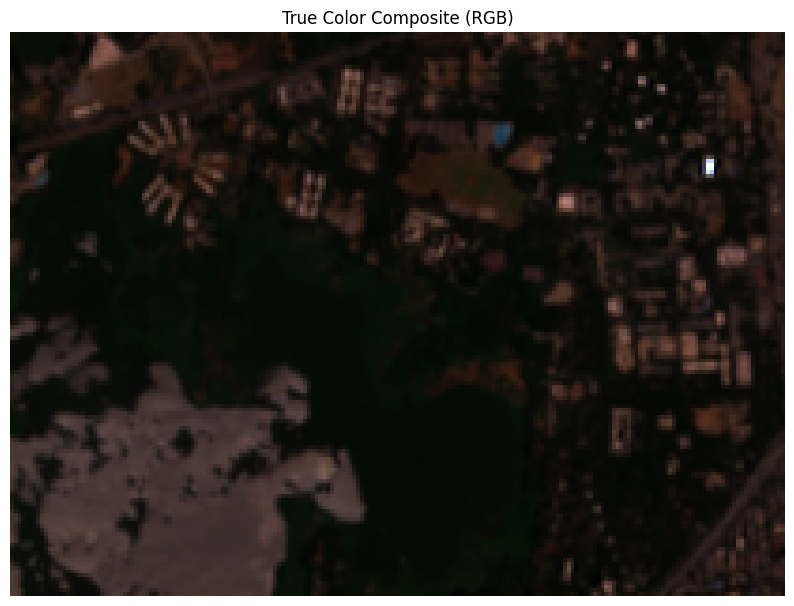

In [43]:
with rasterio.open('C:/Users/Pushp Raj Choudhary/Downloads/combined_multiband_gnr.tif') as src:
    red = src.read(3).astype(float)  # B04
    green = src.read(2).astype(float)  # B03
    blue = src.read(1).astype(float)  # B02

def normalize(band):
    return (band - band.min()) / (band.max() - band.min())

rgb = np.stack([normalize(red), normalize(green), normalize(blue)], axis=-1)

plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title("True Color Composite (RGB)")
plt.axis('off')
plt.show()

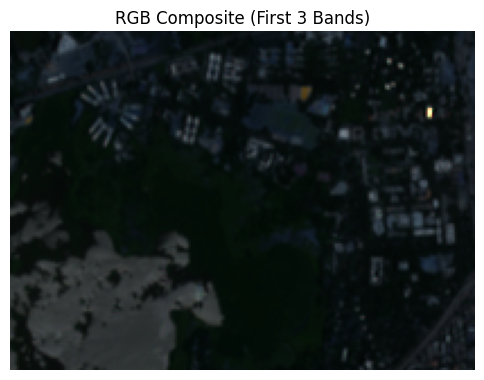

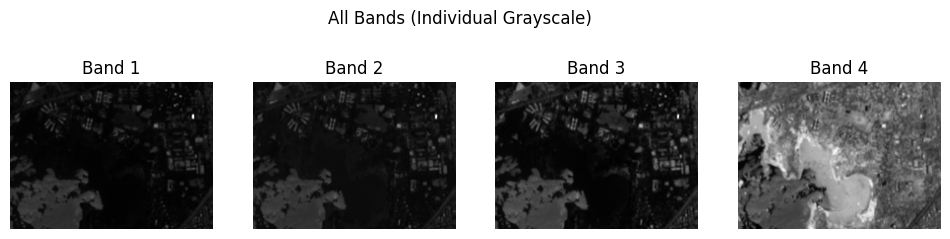

Training SOM with grid size 4x4...


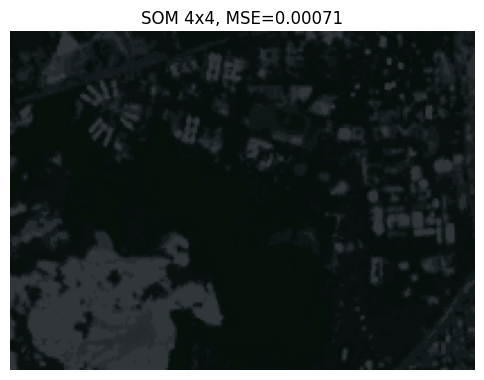

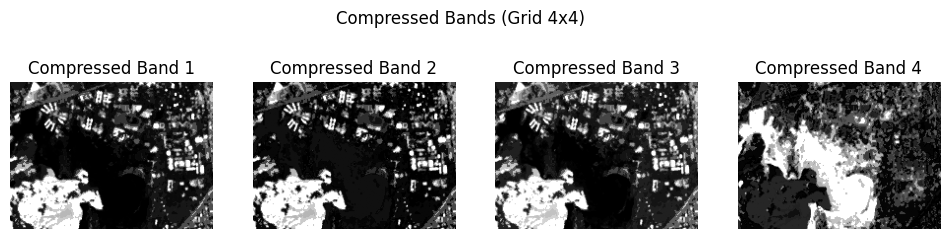

Training SOM with grid size 8x8...


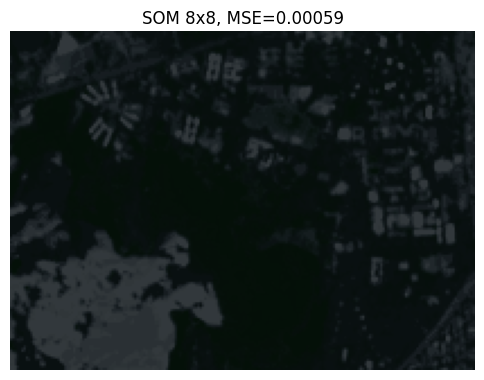

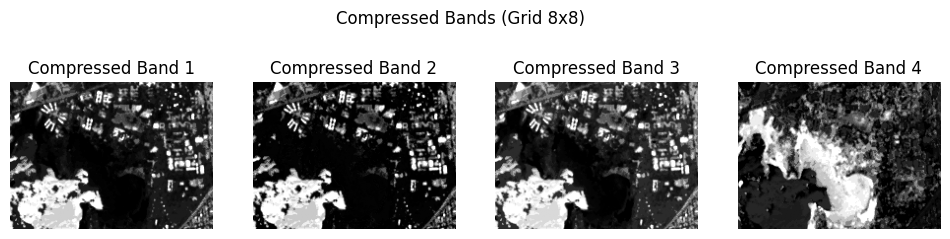

Training SOM with grid size 12x12...


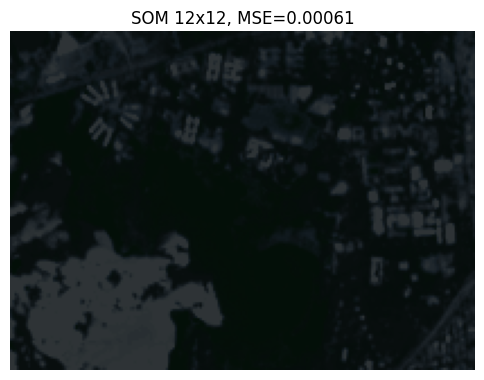

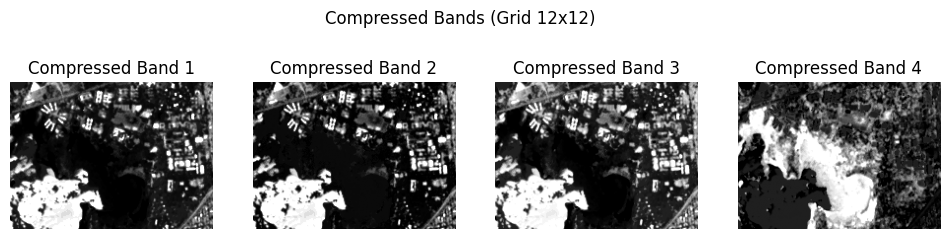

Training SOM with grid size 16x16...


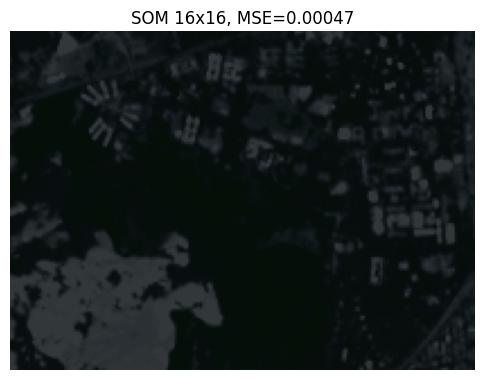

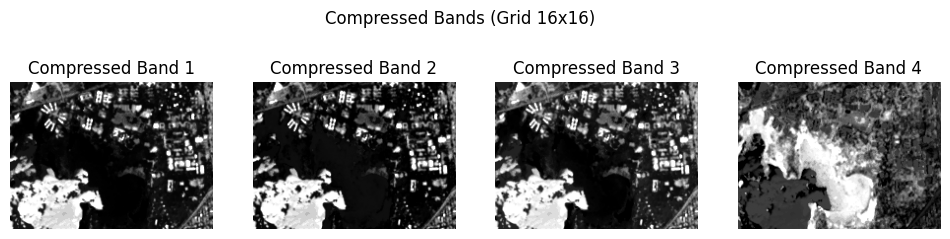

Training SOM with grid size 20x20...


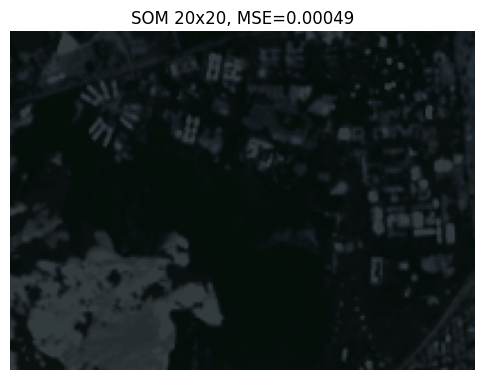

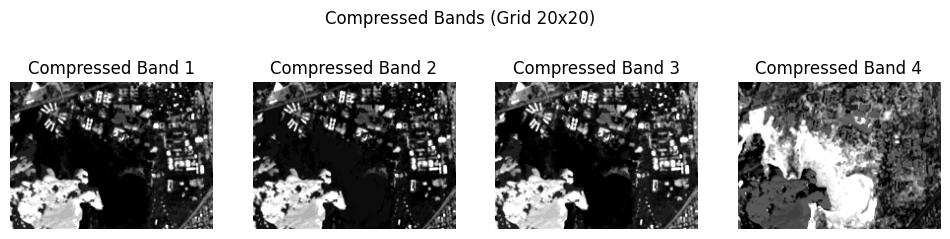

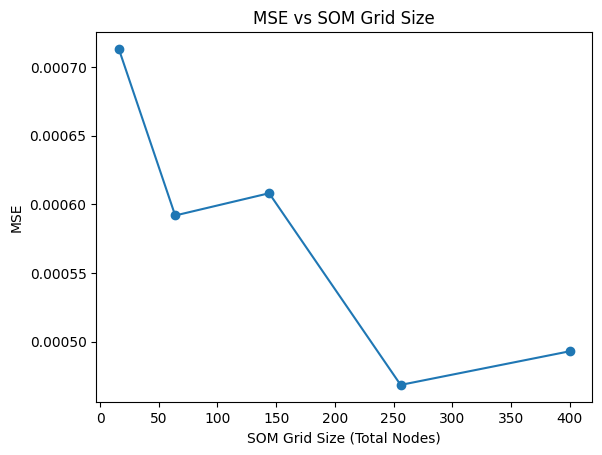

In [44]:
image_path = "C:/Users/Pushp Raj Choudhary/Downloads/combined_multiband_gnr.tif"
img = load_multispectral_image(image_path)

if img.shape[2] >= 3:
    img_vis = img[:, :,:3]
else:
    img_vis = img

plt.figure(figsize=(6, 6))
plt.imshow(img_vis)
plt.title("RGB Composite (First 3 Bands)")
plt.axis('off')
plt.show()

fig, axes = plt.subplots(1, img.shape[2], figsize=(3*img.shape[2], 3))
for b in range(img.shape[2]):
    axes[b].imshow(img[:, :, b], cmap='gray')
    axes[b].set_title(f'Band {b+1}')
    axes[b].axis('off')
plt.suptitle("All Bands (Individual Grayscale)")
plt.show()

grid_sizes = [(4,4), (8,8), (12,12), (16,16), (20,20)]
mses = []

for gx, gy in grid_sizes:
    print(f"Training SOM with grid size {gx}x{gy}...")
    som = SOM(gx, gy, img.shape[2], learning_rate=0.5, max_iter=1000)
    vectors, h, w = img.reshape(-1, img.shape[2]), img.shape[0], img.shape[1]
    som.train(vectors)
    compressed_img = compress_image_with_som(img, som)
    mse = compute_mse(img, compressed_img)
    mses.append(mse)
    plt.figure(figsize=(6, 6))
    plt.imshow(compressed_img[:, :, :3])
    plt.title(f'SOM {gx}x{gy}, MSE={mse:.5f}')
    plt.axis('off')
    plt.show()
    fig, axes = plt.subplots(1, img.shape[2], figsize=(3*img.shape[2], 3))
    for b in range(img.shape[2]):
        axes[b].imshow(compressed_img[:, :, b], cmap='gray')
        axes[b].set_title(f'Compressed Band {b+1}')
        axes[b].axis('off')
    plt.suptitle(f"Compressed Bands (Grid {gx}x{gy})")
    plt.show()

plt.figure()
plt.plot([gx*gy for gx,gy in grid_sizes], mses, marker='o')
plt.xlabel('SOM Grid Size (Total Nodes)')
plt.ylabel('MSE')
plt.title('MSE vs SOM Grid Size')
plt.show()

In [45]:
class SOMGUI:
    def __init__(self, master):
        self.master = master
        master.title("SOM Multispectral Image Clustering")
        self.img = None
        self.compressed_img = None
        self.current_band = 1

        self.load_btn = tk.Button(master, text="Load Image", command=self.load_image)
        self.load_btn.grid(row=0, column=0, columnspan=2, sticky="ew")

        self.grid_label = tk.Label(master, text="Grid Size (4, 8, 12, 16, 20):")
        self.grid_label.grid(row=1, column=0)
        self.grid_size_entry = tk.Entry(master)
        self.grid_size_entry.grid(row=1, column=1)
        self.grid_size_entry.insert(0, "8")

        self.band_slider = tk.Scale(master, from_=1, to=1, orient=tk.HORIZONTAL, label="Band", command=self.update_band)
        self.band_slider.grid(row=2, column=0, columnspan=2, sticky="ew")

        self.run_btn = tk.Button(master, text="Run SOM", command=self.run_som)
        self.run_btn.grid(row=3, column=0, columnspan=2, sticky="ew")

        self.label_band_orig = tk.Label(master, text="", compound='top')
        self.label_band_orig.grid(row=4, column=0)
        self.label_band_comp = tk.Label(master, text="", compound='top')
        self.label_band_comp.grid(row=4, column=1)
        self.label_rgb_orig = tk.Label(master, text="", compound='top')
        self.label_rgb_orig.grid(row=5, column=0)
        self.label_rgb_comp = tk.Label(master, text="", compound='top')
        self.label_rgb_comp.grid(row=5, column=1)

        self.mse_label = tk.Label(master, text="")
        self.mse_label.grid(row=6, column=0, columnspan=2)

        self.tk_img_band_orig = None
        self.tk_img_band_comp = None
        self.tk_img_rgb_orig = None
        self.tk_img_rgb_comp = None

    def load_image(self):
        path = filedialog.askopenfilename()
        if path:
            self.img = load_multispectral_image(path)
            self.compressed_img = None
            self.band_slider.config(to=self.img.shape[2])
            self.current_band = 1
            self.band_slider.set(1)
            self.show_images()

    def run_som(self):
        if self.img is None:
            return
        grid_size = int(self.grid_size_entry.get())
        som = SOM(grid_size, grid_size, self.img.shape[2], learning_rate=0.5, max_iter=500)
        vectors, h, w = self.img.reshape(-1, self.img.shape[2]), self.img.shape[0], self.img.shape[1]
        som.train(vectors)
        self.compressed_img = compress_image_with_som(self.img, som)
        mse = compute_mse(self.img, self.compressed_img)
        self.mse_label.config(text=f"MSE: {mse:.5f}")
        self.show_images()

    def update_band(self, val):
        self.current_band = int(val)
        self.show_images()

    def show_images(self):
        band = self.current_band - 1  

        if self.img is not None:
            band_img = (self.img[:, :, band] * 255).astype(np.uint8)
            band_img = Image.fromarray(band_img)
            band_img = band_img.resize((256, 256))
            self.tk_img_band_orig = ImageTk.PhotoImage(band_img)
            self.label_band_orig.config(image=self.tk_img_band_orig, text=f"Original Band {band+1}", compound='top')
        if self.compressed_img is not None:
            band_img = (self.compressed_img[:, :, band] * 255).astype(np.uint8)
            band_img = Image.fromarray(band_img)
            band_img = band_img.resize((256, 256))
            self.tk_img_band_comp = ImageTk.PhotoImage(band_img)
            self.label_band_comp.config(image=self.tk_img_band_comp, text=f"Compressed Band {band+1}", compound='top')

        def get_rgb(img):
            if img.shape[2] >= 3:
                rgb = img[:, :, :3]
            else:
                rgb = np.repeat(img[:, :, [0]], 3, axis=2)
            rgb = (rgb * 255).astype(np.uint8)
            return Image.fromarray(rgb)

        if self.img is not None:
            rgb_img = get_rgb(self.img).resize((256, 256))
            self.tk_img_rgb_orig = ImageTk.PhotoImage(rgb_img)
            self.label_rgb_orig.config(image=self.tk_img_rgb_orig, text="Original RGB", compound='top')
        if self.compressed_img is not None:
            rgb_img = get_rgb(self.compressed_img).resize((256, 256))
            self.tk_img_rgb_comp = ImageTk.PhotoImage(rgb_img)
            self.label_rgb_comp.config(image=self.tk_img_rgb_comp, text="Compressed RGB", compound='top')

if __name__ == "__main__":
    root = tk.Tk()
    app = SOMGUI(root)
    root.mainloop()